In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pickle
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the SMS data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CODSOFT/sms_spam/spam.csv", encoding="ISO-8859-1", usecols=[0, 1], skiprows=1, names=["label", "message"])
df.label = df.label.map({"ham": 0, "spam": 1})

In [ ]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [ ]:
df.describe()

,label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Data Analysis and Visualization

Plotting the distribution of spam and ham messages

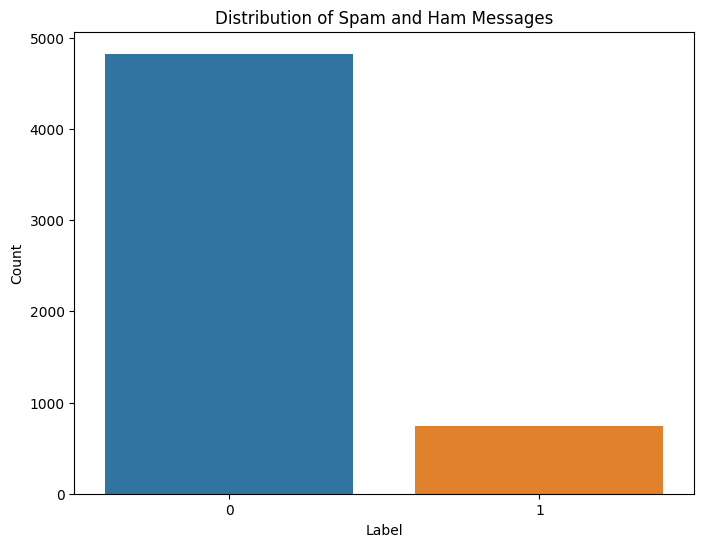

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Spam and Ham Messages')
plt.show()

# Split the Data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df.message, df.label, test_size=0.2)

TF-IDF Feature Extraction

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# Tokenization

In [ ]:
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Padding Sequences

In [ ]:
max_len = 150  # Sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Model training

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 50, input_length=max_len))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Save the best RNN model during training
rnn_model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/CODSOFT/sms_spam/spam_classifier_rnn.h5", save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')




In [ ]:
history = model.fit(X_train_pad, Y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, Y_test), callbacks=[rnn_model_checkpoint])

Epoch 1/5
140/140 [==============================] - 7s 49ms/step - loss: 0.0151 - accuracy: 0.9971 - val_loss: 0.0523 - val_accuracy: 0.9874
Epoch 2/5
140/140 [==============================] - 5s 33ms/step - loss: 0.0132 - accuracy: 0.9975 - val_loss: 0.0519 - val_accuracy: 0.9883
Epoch 3/5
140/140 [==============================] - 6s 47ms/step - loss: 0.0077 - accuracy: 0.9989 - val_loss: 0.0566 - val_accuracy: 0.9883
Epoch 4/5
140/140 [==============================] - 5s 37ms/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.0518 - val_accuracy: 0.9883
Epoch 5/5
140/140 [==============================] - 5s 32ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0538 - val_accuracy: 0.9892


Plotting the training and validation accuracy over epochs

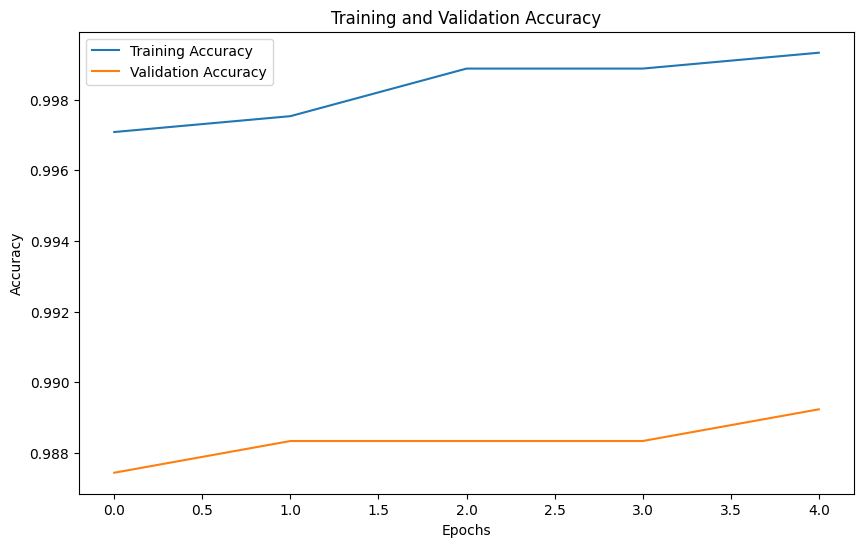

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

 Plot the training and validation loss over epochs

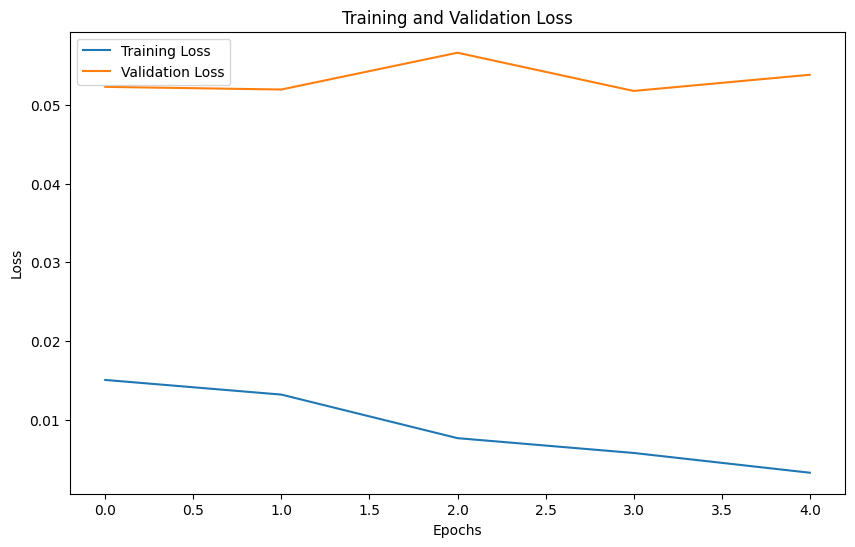

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Choose a classifier (e.g., Naive Bayes)
classifier = MultinomialNB()  # Change this to the classifier of your choice

In [ ]:
# Train the classifier using TF-IDF features
classifier.fit(tfidf_train, Y_train)

MultinomialNB()

In [ ]:
rnn_model_filename = "/content/drive/MyDrive/CODSOFT/sms_spam/spam_classifier_rnn.h5"
shutil.move("/content/drive/MyDrive/CODSOFT/sms_spam/spam_classifier_rnn.h5", rnn_model_filename)

'/content/drive/MyDrive/CODSOFT/sms_spam/spam_classifier_rnn.h5'

 Save Tokenizer

In [ ]:
with open("/content/drive/MyDrive/CODSOFT/sms_spam/tokenizer_rnn.pkl", "wb") as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

#Model evaluation

In [ ]:
# evaluation results
rnn_accuracy, _ = model.evaluate(X_test_pad, Y_test, verbose=0)
print("RNN Model Evaluation:")
print(f"Accuracy: {rnn_accuracy:.2f}")

RNN Model Evaluation:
Accuracy: 0.05


Evaluate the Classifier

In [ ]:
tfidf_test_predictions = classifier.predict(tfidf_test)
tfidf_accuracy = np.mean(tfidf_test_predictions == Y_test)
print(f"Classifier Evaluation Accuracy: {tfidf_accuracy:.2f}")

Classifier Evaluation Accuracy: 0.96


Create a confusion matrix for the classifier

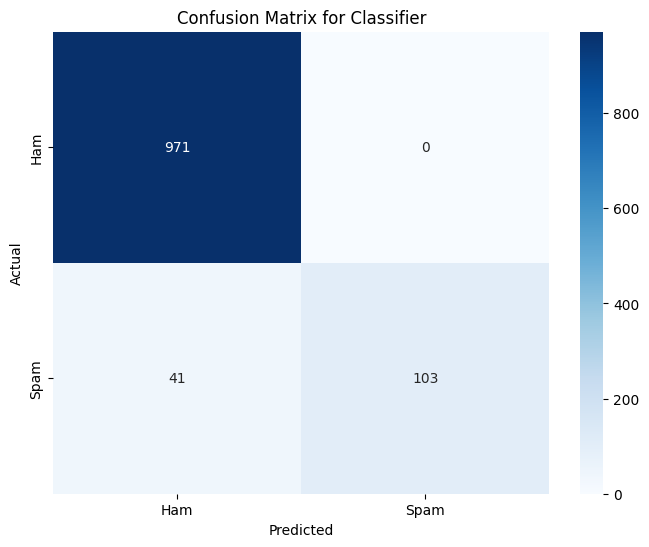

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, tfidf_test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classifier')
plt.show()

The classification results

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
with open("/content/drive/MyDrive/CODSOFT/sms_spam/tokenizer_rnn.pkl", "rb") as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)
model = load_model("/content/drive/MyDrive/CODSOFT/sms_spam/spam_classifier_rnn.h5")
def classify_message(message):
    message_seq = tokenizer.texts_to_sequences([message])
    message_pad = pad_sequences(message_seq, maxlen=max_len)
    prediction = model.predict(message_pad)

    if prediction[0] >= 0.5:
        return "spam"
    else:
        return "ham"
input_message = input("Enter a message to classify: ")
result = classify_message(input_message)

print(f"The message is classified as: {result}")


Enter a message to classify: England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/̼1.20 POBOXox36504W45WQ 16+
1/1 [==============================] - 0s 243ms/step
The message is classified as: spam
